## 1. Import the necessary libraries



In [1]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots



from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import warnings
#https://www.kaggle.com/datatattle/predicting-loan-default-classification

## 2. Read in the train and test data

In [2]:
train = pd.read_csv("../input/dish-network-hackathon/Train_Dataset.csv", 
                    low_memory=False)
        
test = pd.read_csv("../input/dish-network-hackathon/Test_Dataset.csv",
                  low_memory=False)

In [3]:
#Shape of dataframe
print(" Shape of training dataframe: ", train.shape)
print(" Shape of testing dataframe: ", test.shape)

# Drop duplicates
train.drop_duplicates()
test.drop_duplicates()
print(train.shape)
print(test.shape)

 Shape of training dataframe:  (121856, 40)
 Shape of testing dataframe:  (80900, 39)
(121856, 40)
(80900, 39)


## 3. Check some sample rows

In [4]:
train.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957,1062,6123,383,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162,4129,7833,21,0.0,1,0,1,NaN,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,Service,Graduation dropout,W,Male,CL,Family,0.0228,16790,5102,NaN,331,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655054,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195,365243,NaN,775,NaN,1,0,0,NaN,2.0,3.0,2.0,15.0,Yes,Yes,XNA,NaN,0.135182,0.631354537,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366,2977,5516,4043,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355638717,0.2021,674.0,1.0,0


#### There are lot of NAN values, so we would need to impute those before modeling
#### Let us see the total NAN values for each variable in the dataset

In [5]:

null= train.isnull().sum().sort_values(ascending=False)
total =train.shape[0]
percent_missing= (train.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, 
                        keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", 
       missing_data.sort_values(by ='Total missing', ascending = False))

Null Values in each column:
                    column name  Total missing  Percent missing
0                Own_House_Age          80095         0.657292
1               Score_Source_1          68835         0.564888
2        Social_Circle_Default          61928         0.508206
3            Client_Occupation          41435         0.340032
4               Score_Source_3          26921         0.220925
5                Credit_Bureau          18540         0.152147
6                      ID_Days           5968         0.048976
7               Score_Source_2           5686         0.046662
8   Population_Region_Relative           4857         0.039859
9                 Loan_Annuity           4812         0.039489
10          Client_Income_Type           3701         0.030372
11         Client_Housing_Type           3687         0.030257
12                Phone_Change           3664         0.030068
13    Application_Process_Hour           3663         0.030060
14                   House

### Almost all the variables except ID, some client variables, phone variables and default have missing values

In [6]:
class_df = train.groupby('Default').count()['ID'].reset_index().sort_values(by='ID',ascending=False)
class_df.style.background_gradient(cmap='winter')

,Default,ID
0,0,112011
1,1,9845


In [7]:
train_null_unique= train.Own_House_Age.unique()
test_null_unique= test.Own_House_Age.unique()
print(train_null_unique)
print (test_null_unique)

[nan  0.  6. 10. 14.  1.  3.  2.  7. 15. 31. 16. 13. 64.  8. 20. 17.  4.
 18. 22.  9.  5. 23. 12. 32. 27. 50. 19. 29. 24. 65. 11. 25. 26. 30. 28.
 39. 21. 44. 35. 33. 37. 40. 36. 34. 41. 57. 45. 38. 43. 63. 42. 54. 49.
 69. 46.]
[nan  6.  7.  4.  3. 15. 17. 14. 12. 10.  1.  5. 18.  0.  2. 11.  9.  8.
 23. 16. 25. 13. 37. 21. 24. 65. 64. 28. 22. 20. 19. 27. 26. 34. 32. 29.
 31. 30. 39. 46. 40. 36. 33. 41. 35. 45. 42. 38. 43. 44. 49. 63. 54. 55.
 51.]


In [8]:
#plt.figure(figsize = (20, 12))
#sns.countplot(train.Own_House_Age);

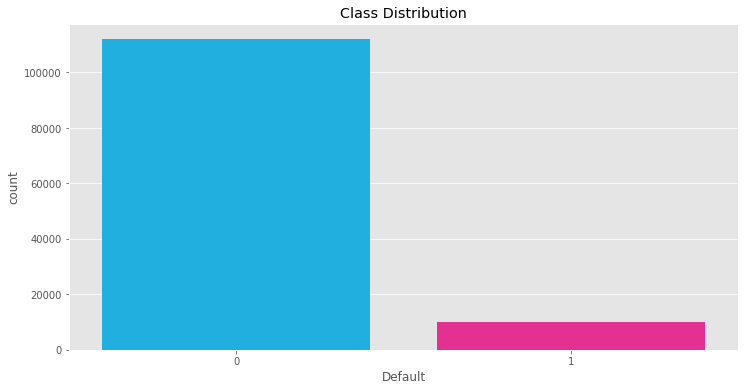

% of no defaults       : 91.92079175420169
Number of no defaults     : 112011
% of defaults         : 8.07920824579832
Number of defaults    : 9845


In [9]:
#Graph
my_pal = {0: 'deepskyblue', 1: 'deeppink'}

plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'Default', data = train, palette = my_pal)
plt.title('Class Distribution')
plt.show()

# Count and %
Count_Normal_transacation = len(train[train['Default']==0])
Count_Fraud_transacation = len(train[train['Default']==1]) 
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of no defaults       :', Percentage_of_Normal_transacation*100)
print('Number of no defaults     :', Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of defaults         :',Percentage_of_Fraud_transacation*100)
print('Number of defaults    :', Count_Fraud_transacation)

### Highly skewed distribution with 8% defaults and 92% no defaults, so a naive model which predicts no default for all records will have 92% accuracy

In [10]:
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()
    
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = train.loc[train['Default'] != 0]
    t0 = train.loc[train['Default'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="Default = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="Default = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [11]:
def plot_bar_comp(var,nrow=2):
    
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.countplot(train[feature])
        sns.countplot(train[feature])
        plt.ylabel('Count plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [12]:
# Box Plot for one feature
def plot_box(feature, color):
    plt.figure(figsize=(10,6))
    plt.title("Box Plot of %s" % feature)
    sns.boxplot(y=train[feature].dropna(),x= train.Default,color=color)
    plt.show()

In [13]:
# Bar Plot for one feature
def plot_bar(feature):
    plt.figure(figsize=(10,50))
    sns.catplot(y=feature, hue="Default", kind="count",
            palette="pastel", edgecolor=".6",
            data=train);

count    41761.000000
mean        12.157324
std         12.056079
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         69.000000
Name: Own_House_Age, dtype: float64


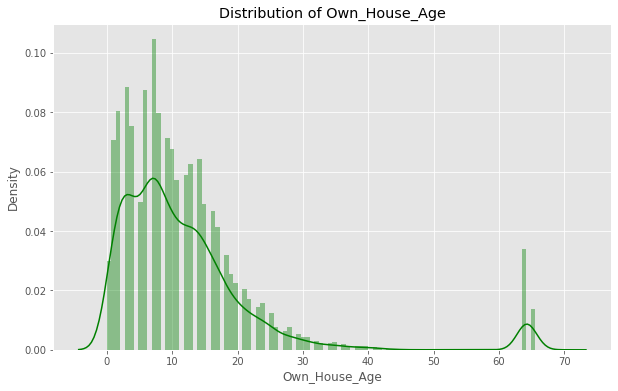

In [14]:
print(train.Own_House_Age.describe())
plot_distribution('Own_House_Age','green')

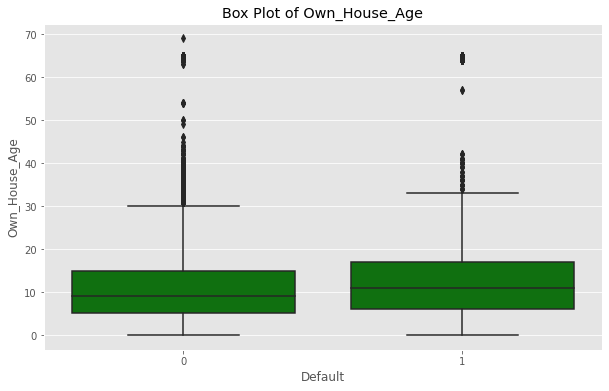

In [15]:
plot_box("Own_House_Age", "green")

### We can see that there are lot of outliers, let us find how many outliers are there in total

In [16]:
#Number of observations in column
obs = len(train.Own_House_Age)
print("No. of observations in column: ",obs)

# calculate summary statistics
data_mean, data_std = mean(train.Own_House_Age), std(train.Own_House_Age)
print('Statistics: Mean=%.3f, Std dev=%.3f' % (data_mean, data_std))
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in train.Own_House_Age if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

No. of observations in column:  121856
Statistics: Mean=12.157, Std dev=12.056
Identified outliers: 1379


In [17]:
def impute_outlier(x):
    if x <= lower:
        return(data_mean)
    elif x>= (upper):
        return(data_mean)
    else:
        return(x)
train["Own_House_Age_new"]= train["Own_House_Age"].apply(impute_outlier)
print("No. of observations in column: ",len(train.Own_House_Age_new))

No. of observations in column:  121856


In [18]:
def impute_missing(x):
    if x == np.nan:
        return(median(x))
    else:
        return(x)

train["Own_House_Age_new"]= train["Own_House_Age"].apply(impute_missing)
print("No. of observations in column: ",len(train.Own_House_Age_new))
    

No. of observations in column:  121856


In [19]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
train['Own_House_Age_bins'] = pd.qcut(train['Own_House_Age'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
train['Own_House_Age_bins'].value_counts()

Low        11384
High       10351
Extreme    10131
Medium      9895
Name: Own_House_Age_bins, dtype: int64

<Figure size 720x3600 with 0 Axes>

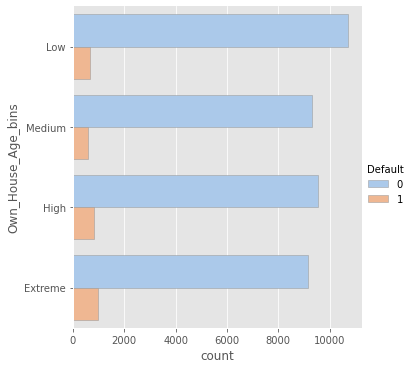

In [20]:
plot_bar("Own_House_Age_bins")

### There is a tendency to default more of the age of the house is more based on above chart

count               53021.0
mean     0.5012129250527902
std      0.2112044486112907
min             0.014568132
25%             0.333480523
50%             0.504656688
75%             0.673890059
max             0.945741288
Name: Score_Source_1, dtype: object


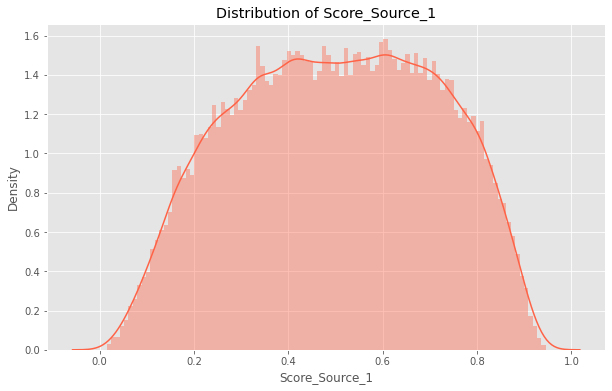

In [21]:
print(train.Score_Source_1.describe().astype(str))
plot_distribution('Score_Source_1','tomato')

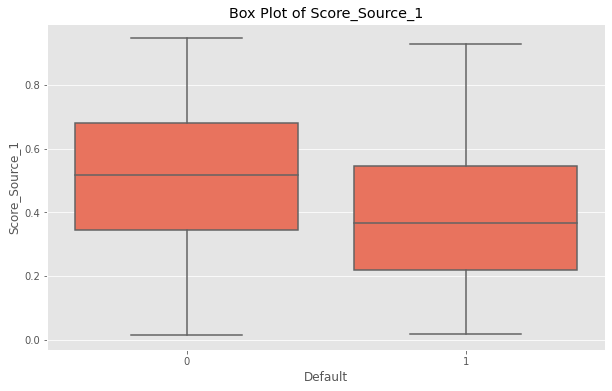

In [22]:
plot_box("Score_Source_1", "tomato")

### There are no outliers, so we just need to replace the missing values with median as the distribution is nearly normal

In [23]:
#def impute_missing(x):
#    if x == np.nan:
#        return(median(x))
#    else:
#        return(x)
train["Score_Source_1_new"]= train["Score_Source_1"].apply(impute_missing)
print("No. of observations in column: ",len(train.Score_Source_1_new))

No. of observations in column:  121856


In [24]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
train['Score_Source_1_bins'] = pd.qcut(train['Score_Source_1'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
train['Score_Source_1_bins'].value_counts()

Low        13257
High       13257
Medium     13254
Extreme    13253
Name: Score_Source_1_bins, dtype: int64

<Figure size 720x3600 with 0 Axes>

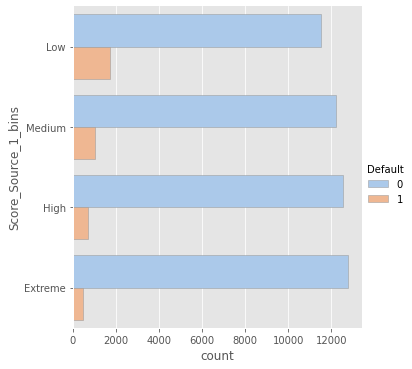

In [25]:
plot_bar("Score_Source_1_bins")

### There is a tendency to default more at lower scores than higher scores

count                59928.0
mean     0.11742785509277799
std      0.10797382393875056
min                      0.0
25%                   0.0577
50%                   0.0887
75%                   0.1485
max                      1.0
Name: Social_Circle_Default, dtype: object


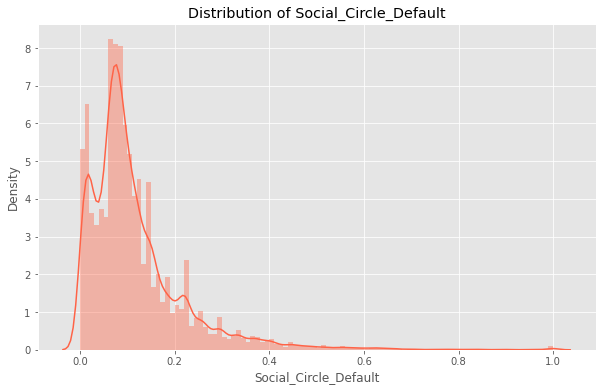

In [26]:
print(train.Social_Circle_Default.describe().astype(str))
plot_distribution('Social_Circle_Default','tomato')

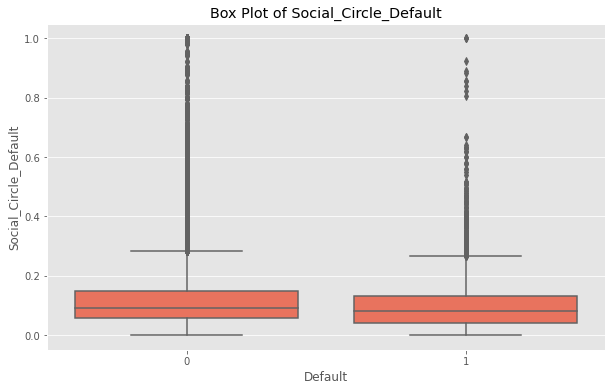

In [27]:
plot_box("Social_Circle_Default", "tomato")

In [28]:
train["Social_Circle_Default_new"]= train["Social_Circle_Default"].apply(impute_missing)
print("No. of observations in column: ",len(train.Social_Circle_Default_new))

No. of observations in column:  121856


In [29]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
train['Social_Circle_Default'] = pd.qcut(train['Social_Circle_Default'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
train['Social_Circle_Default'].value_counts()

High       15826
Low        15112
Medium     14963
Extreme    14027
Name: Social_Circle_Default, dtype: int64

<Figure size 720x3600 with 0 Axes>

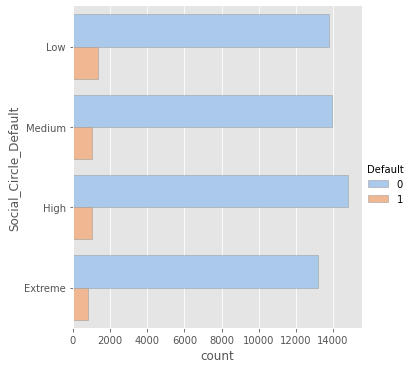

In [30]:
plot_bar("Social_Circle_Default");

### Lower social circle score has more probability of default